# Section 1 — Objective & Environment

## Section 1 — Objective & Environment

The objective of this lab is to study reinforcement learning algorithms in a
classic control setting using the CartPole environment. The task is to learn a
policy that balances a pole on a moving cart by applying discrete left/right
actions based on continuous state observations.

CartPole is chosen because it is:
- Simple yet non-trivial
- Continuous-state, discrete-action
- A standard benchmark for both tabular and deep RL methods

Two approaches are implemented:
1. Tabular Q-learning using discretized state space
2. Deep Q-Network (DQN) using function approximation

# Section 2 — Environment Setup & Reproducibility

In [25]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import os

In [26]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [27]:
env = gym.make("CartPole-v1")

env.reset(seed=SEED)
env.action_space.seed(SEED)

42

In [28]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)


In [29]:
state, _ = env.reset()
total_reward = 0

for _ in range(200):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break

print("Random policy episode reward:", total_reward)

Random policy episode reward: 29.0


# Section 3 — Tabular Q-Learning (Discretized State)

## Why Discretization?

### CartPole provides a continuous 4-dimensional state. Tabular Q-learning requires a finite state space, so each dimension is discretized into coarse bins. This trades precision for tractability and allows a simple Q-table implementation.

In [30]:
# Discretization bins
NUM_BINS = (6, 6, 6, 6)

# State bounds
STATE_BOUNDS = [
    (-4.8, 4.8),    # cart position
    (-3.0, 3.0),    # cart velocity
    (-0.418, 0.418),# pole angle (~24 degrees)
    (-3.5, 3.5)     # pole angular velocity
]

def discretize_state(state):
    """Map continuous state to discrete bins."""
    discretized = []
    for i, (low, high) in enumerate(STATE_BOUNDS):
        val = np.clip(state[i], low, high)
        bins = np.linspace(low, high, NUM_BINS[i] + 1)
        discretized.append(np.digitize(val, bins) - 1)
    return tuple(discretized)

In [31]:
NUM_ACTIONS = env.action_space.n

Q = np.zeros(NUM_BINS + (NUM_ACTIONS,))

In [32]:
ALPHA = 0.1      # learning rate
GAMMA = 0.99     # discount factor
EPSILON = 1.0    # exploration rate
EPS_MIN = 0.05
EPS_DECAY = 0.995

EPISODES = 500
MAX_STEPS = 500

In [33]:
# Training loop
episode_rewards = []

for episode in range(EPISODES):
    state, _ = env.reset(seed=SEED + episode)
    state_d = discretize_state(state)
    total_reward = 0

    for _ in range(MAX_STEPS):
        # ε-greedy action selection
        if np.random.rand() < EPSILON:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state_d])

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state_d = discretize_state(next_state)

        # Q-learning update
        best_next = np.max(Q[next_state_d])
        Q[state_d + (action,)] += ALPHA * (
            reward + GAMMA * best_next - Q[state_d + (action,)]
        )

        state_d = next_state_d
        total_reward += reward

        if terminated or truncated:
            break

    # Decay exploration
    EPSILON = max(EPS_MIN, EPSILON * EPS_DECAY)
    episode_rewards.append(total_reward)

    if (episode + 1) % 50 == 0:
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {EPSILON:.3f}")

Episode 50, Reward: 16.0, Epsilon: 0.778
Episode 100, Reward: 28.0, Epsilon: 0.606
Episode 150, Reward: 58.0, Epsilon: 0.471
Episode 200, Reward: 37.0, Epsilon: 0.367
Episode 250, Reward: 56.0, Epsilon: 0.286
Episode 300, Reward: 18.0, Epsilon: 0.222
Episode 350, Reward: 28.0, Epsilon: 0.173
Episode 400, Reward: 43.0, Epsilon: 0.135
Episode 450, Reward: 22.0, Epsilon: 0.105
Episode 500, Reward: 38.0, Epsilon: 0.082


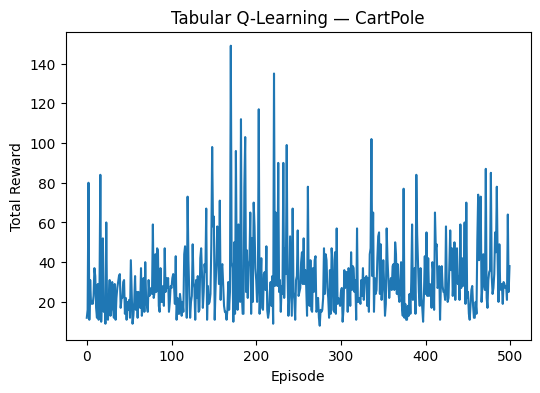

In [34]:
plt.figure(figsize=(6,4))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Tabular Q-Learning — CartPole")
plt.show()

In [35]:
os.makedirs("models", exist_ok=True)
np.save("models/cartpole_q_table.npy", Q)

## Section 3 Summary — Tabular Q-Learning

- Tabular Q-learning was implemented by discretizing the continuous CartPole state
space into coarse bins. Over training, the agent demonstrates gradual improvement
in episode rewards, confirming that the Q-learning update rule is functioning
correctly.

- However, learning remains unstable and rewards plateau at relatively low values.
This behavior is expected due to information loss introduced by discretization,
limited state resolution, and the inability of tabular methods to generalize
across unseen states in continuous environments.

- These limitations motivate the use of function approximation methods, such as
Deep Q-Networks (DQN), which can directly operate on continuous state spaces and
exhibit improved stability and sample efficiency.

# Section 4 — Deep Q-Network (DQN)

## Section 4 — Deep Q-Network (DQN)

- To address the limitations of tabular Q-learning in continuous state spaces,
a Deep Q-Network (DQN) is used to approximate the action–value function directly
from raw observations. Experience replay and a target network are employed to
improve training stability.

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [37]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [38]:
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return s, a, r, s2, d

    def __len__(self):
        return len(self.buffer)

In [39]:
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n

LR = 1e-3
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 100_000
TARGET_UPDATE = 500
EPISODES = 600
MAX_STEPS = 500

EPSILON = 1.0
EPS_MIN = 0.05
EPS_DECAY = 0.995

In [40]:
policy_net = QNetwork(STATE_DIM, ACTION_DIM).to(device)
target_net = QNetwork(STATE_DIM, ACTION_DIM).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
replay_buffer = ReplayBuffer(BUFFER_SIZE)

In [41]:
dqn_rewards = []
step_count = 0

for ep in range(EPISODES):
    state, _ = env.reset(seed=SEED + ep)
    total_reward = 0

    for _ in range(MAX_STEPS):
        step_count += 1

        # ε-greedy action
        if random.random() < EPSILON:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                action = policy_net(s).argmax(dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Learn
        if len(replay_buffer) >= BATCH_SIZE:
            s, a, r, s2, d = replay_buffer.sample(BATCH_SIZE)

            s  = torch.tensor(s, dtype=torch.float32, device=device)
            a  = torch.tensor(a, dtype=torch.int64, device=device).unsqueeze(1)
            r  = torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1)
            s2 = torch.tensor(s2, dtype=torch.float32, device=device)
            d  = torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1)

            q_vals = policy_net(s).gather(1, a)
            with torch.no_grad():
                q_next = target_net(s2).max(1, keepdim=True)[0]
                q_target = r + GAMMA * q_next * (1 - d)

            loss = nn.MSELoss()(q_vals, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Target network update
        if step_count % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            break

    EPSILON = max(EPS_MIN, EPSILON * EPS_DECAY)
    dqn_rewards.append(total_reward)

    if (ep + 1) % 50 == 0:
        print(f"Episode {ep+1}, Reward: {total_reward}, Epsilon: {EPSILON:.3f}")

Episode 50, Reward: 12.0, Epsilon: 0.778
Episode 100, Reward: 27.0, Epsilon: 0.606
Episode 150, Reward: 252.0, Epsilon: 0.471
Episode 200, Reward: 83.0, Epsilon: 0.367
Episode 250, Reward: 19.0, Epsilon: 0.286
Episode 300, Reward: 29.0, Epsilon: 0.222
Episode 350, Reward: 19.0, Epsilon: 0.173
Episode 400, Reward: 101.0, Epsilon: 0.135
Episode 450, Reward: 128.0, Epsilon: 0.105
Episode 500, Reward: 103.0, Epsilon: 0.082
Episode 550, Reward: 104.0, Epsilon: 0.063
Episode 600, Reward: 130.0, Epsilon: 0.050


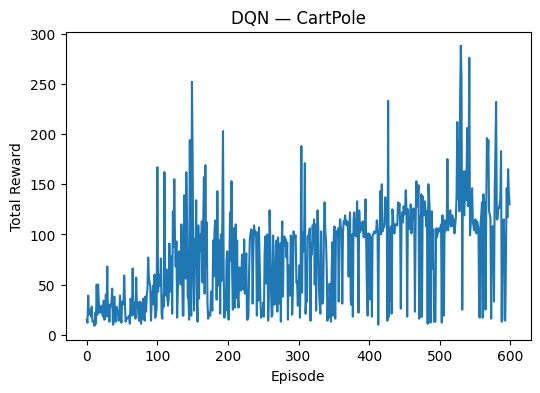

In [42]:
plt.figure(figsize=(6,4))
plt.plot(dqn_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN — CartPole")
plt.show()

In [43]:
os.makedirs("models", exist_ok=True)
torch.save(policy_net.state_dict(), "models/cartpole_dqn.pt")

### Section 4 Summary

A Deep Q-Network was trained directly on the continuous CartPole state space.
Compared to tabular Q-learning, DQN exhibits faster learning and improved
stability due to function approximation, experience replay, and the use of a
target network. The resulting reward curve demonstrates clear performance gains,
highlighting the limitations of discretized tabular methods in continuous
environments.

# Section 5 — Learning Stability & Divergence Analysis

## The DQN agent demonstrates significantly improved performance compared to the tabular Q-learning approach. Episode rewards increase rapidly after sufficient experience is collected, with multiple episodes achieving near-maximum reward. However, training exhibits intermittent instability, with sharp drops in reward between high-performing episodes.

## Why Instability Occurs in DQN

Training instability in DQN arises from the combination of function approximation,
bootstrapping, and off-policy learning:

- **Function approximation**: The neural network generalizes across states, which
  can introduce approximation errors.
- **Bootstrapping**: Target values depend on the network’s own predictions, which
  can propagate errors.
- **Non-stationary targets**: Policy updates continually change the data
  distribution.
- **Exploration effects**: ε-greedy exploration can temporarily degrade
  performance even after strong policies are learned.

The use of experience replay and a target network mitigates—but does not eliminate—
these sources of instability.

## Comparison with Tabular Q-Learning

- Tabular Q-learning exhibited slower learning and lower asymptotic performance due
to coarse discretization and lack of generalization. In contrast, DQN operates
directly on continuous state representations, enabling faster learning and higher
final rewards at the cost of increased training variance.

## Summary
- Deep Q-Networks provide a substantial performance improvement over tabular
Q-learning in continuous control tasks such as CartPole. While DQN achieves
higher rewards and better generalization, it introduces training instability due
to function approximation and bootstrapping. These trade-offs highlight the
importance of stabilization techniques in deep reinforcement learning.